# Two Layer 네트워크 학습

In [1]:
import numpy as np

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    c = np.max(x)
    exp_x = np.exp(x - c)
    sum_exp_x = np.sum(exp_x)
    y = exp_x / sum_exp_x
    return y

def cross_entropy_error(y, t):
    if y.ndim == 1:
        y = y.reshape(1, y.size)
        t = t.reshape(1, t.size)
    if y.size == t.size:
        t = t.argmax(axis=1)
    batch = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch), t] + 1e-7) / batch)
cee = cross_entropy_error

def numerical_gradient(f, x):
    h = 1e-4
    gradient = np.zeros_like(x)
    iter = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not iter.finished:
        index = iter.multi_index
        each = x[index]
        
        x[index] = float(each) + h
        f_xh_1 = f(x)

        x[index] = float(each) - h
        f_xh_2 = f(x)

        gradient = (f_xh_1 - f_xh_2) / (2 * h)

        x[index] = each
        iter.iternext()
    return gradient
numgrad = numerical_gradient

In [3]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
    
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']

        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)

        a2 = np.dot(z1, W2) + b2
        z2 = softmax(a2)

        y = z2
        return y

    def loss(self, x, t):
        y = self.predict(x)
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.prediuct(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        def loss(_W):
            return self.loss(x, t)
        gradients = {}
        gradients['W1'] = numerical_gradient(loss, self.params['W1'])
        gradients['b1'] = numerical_gradient(loss, self.params['b1'])
        gradients['W2'] = numerical_gradient(loss, self.params['W2'])
        gradients['b2'] = numerical_gradient(loss, self.params['b2'])
        return gradients

## 학습

In [4]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import MinMaxScaler

In [5]:
def convert_one_hot(arr):
    unique, inverse = np.unique(arr, return_inverse=True)
    onehot = np.eye(unique.shape[0])[inverse]
    return onehot

In [6]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

scaler = MinMaxScaler(feature_range=(0, 1))
X_train = (X_train / 255.0).reshape(60_000, 784)
X_test = (X_test / 255.0).reshape(10_000, 784)
y_train = convert_one_hot(y_train)
y_test = convert_one_hot(y_test)


In [7]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

epochs = 10
train_size = X_train.shape[0]
batch_size = 100
learning_rate = .1

train_losses = []

starts_at = time.time()
for i in range(epochs):
    index_selected = np.random.choice(train_size, batch_size)
    each_X = X_train[index_selected]
    each_y = y_train[index_selected]

    gradient = network.numerical_gradient(each_X, each_y)

    for each_param in ['W1', 'b1', 'W2', 'b2']:
        network.params[each_param] -= learning_rate * gradient[each_param]
    
    loss = network.loss(each_X, each_y)
    train_losses.append(loss)

    print(f'loss: {loss}')

ends_at = time.time()

print(f'Training done in {ends_at - starts_at}.')

loss: 6.9080029203498325
loss: 6.905910192564317
loss: 6.905012040393604
loss: 6.907558508841199
loss: 6.908091070398621
loss: 6.901338127239348
loss: 6.904252583212801
loss: 6.909144802000959
loss: 6.907457732336448
loss: 6.908834994417812
Training done in 564.0043697357178.


[0.10112799 0.10027828 0.09452242 0.10144697 0.1011619  0.09586833
 0.09910983 0.10254669 0.10459624 0.09934134] 8


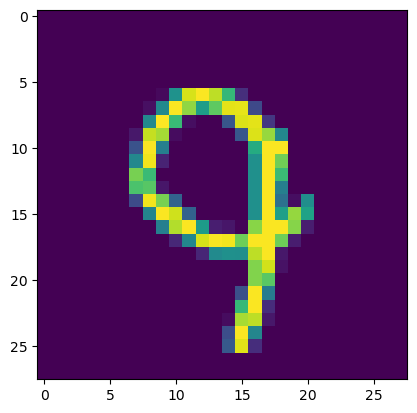

In [8]:
index = 999
image = X_test[index].reshape(28, 28)
plt.imshow(image)

y = network.predict(X_test[index])
pred = np.argmax(y)
print(y, pred)